In [4]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import pickle

import warnings
warnings.filterwarnings('ignore')

In [5]:
# Read in the dataset
date_parser = lambda x: pd.to_datetime(x, format='%d/%m/%Y %H:%M')
df = pd.read_csv('dseats_2024_training_dataset.csv', parse_dates=['PRODUCTION DATE'], date_parser=date_parser)

# Data Preparation

In [6]:
# Check dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6925 entries, 0 to 6924
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   PRODUCTION DATE                6925 non-null   datetime64[ns]
 1   Field Name                     6925 non-null   object        
 2   WELL_BORE_CODE                 6925 non-null   object        
 3   N_WELL_BORE_CODE               6925 non-null   int64         
 4   WellBore Name                  6925 non-null   object        
 5   FLOW_KIND                      6925 non-null   object        
 6   WELL_TYPE                      6925 non-null   object        
 7   Downhole Pressure (PSI)        6925 non-null   float64       
 8   Downhole Temperature (Kelvin)  6925 non-null   float64       
 9   Average Tubing Pressure        6925 non-null   float64       
 10  Annulus Pressure (PSI)         6925 non-null   float64       
 11  AVG WHP (PSI)    

In [7]:
# Check the first few rows
df.head()

,PRODUCTION DATE,Field Name,WELL_BORE_CODE,N_WELL_BORE_CODE,WellBore Name,FLOW_KIND,WELL_TYPE,Downhole Pressure (PSI),Downhole Temperature (Kelvin),Average Tubing Pressure,Annulus Pressure (PSI),AVG WHP (PSI),Choke Size,Oil Production (stb/day),Gas Volume (scf/day),Water Production (stb/day)
0,2014-04-07,DSEAT,DSEAT-001-F-1 C,105,001-F-1 C,production,OP,0.00000,273.15000,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.0
1,2014-04-08,DSEAT,DSEAT-001-F-1 C,105,001-F-1 C,production,OP,0.00000,273.15000,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.0
2,2014-04-09,DSEAT,DSEAT-001-F-1 C,105,001-F-1 C,production,OP,0.00000,273.15000,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.0
3,2014-04-10,DSEAT,DSEAT-001-F-1 C,105,001-F-1 C,production,OP,0.00000,273.15000,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.0
4,2014-04-11,DSEAT,DSEAT-001-F-1 C,105,001-F-1 C,production,OP,4500.45403,370.02589,4020.53477,0.0,479.91926,33.07195,0.0,0.0,0.0


# Exploratory Data Analysis

In [8]:
# Check for duplicate records
if df.duplicated().any():
  print(f"There are {df.duplicated().sum()} duplicate records")
else:
  print("There are no duplicate records")

There are no duplicate records


In [9]:
# Check for null values
null_cols = df.isna().sum().tolist()
for i in null_cols:
  if i > 0:
    print(f"{i} null values in {df.columns[null_cols.index(i)]}")

6 null values in Choke Size


In [10]:
# Check values in N_WELL_BORE_CODE
print(f"The unique values in N_WELL_BORE_CODE are {df['N_WELL_BORE_CODE'].unique()}")

The unique values in N_WELL_BORE_CODE are [105 106 107 108 109]


In [11]:
# Convert N_WELL_BORE_CODE to object
df['N_WELL_BORE_CODE'] = df['N_WELL_BORE_CODE'].astype(str)

In [12]:
# Check descriptive statistics
df.describe()

,PRODUCTION DATE,Downhole Pressure (PSI),Downhole Temperature (Kelvin),Average Tubing Pressure,Annulus Pressure (PSI),AVG WHP (PSI),Choke Size,Oil Production (stb/day),Gas Volume (scf/day),Water Production (stb/day)
count,6925,6925.000000,6925.000000,6925.000000,6925.000000,6925.000000,6919.000000,6925.000000,6.925000e+03,6925.000000
mean,2012-07-04 23:09:15.725631744,2587.482923,349.674794,2161.986343,180.369383,716.576882,21.864557,8494.774524,6.978690e+06,11480.559310
min,2008-02-12 00:00:00,0.000000,273.150000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-2879.813600
25%,2010-07-04 00:00:00,0.000000,273.150000,896.612291,0.000000,476.539814,4.631982,1686.600600,1.434288e+06,80.323300
50%,2013-01-20 00:00:00,3378.397358,376.911370,2472.031527,213.091127,619.647824,14.301660,5479.470600,4.770461e+06,5529.413200
75%,2014-07-19 00:00:00,3664.905359,379.496193,2907.047474,300.356843,903.890487,31.529768,11730.472600,9.892230e+06,22261.505100
max,2015-06-30 00:00:00,4606.666675,381.652178,4592.612695,435.287508,1991.009935,125.718570,37122.573600,3.004494e+07,50444.164600
std,NaN,1588.474034,46.240823,1053.875029,139.771514,347.859953,22.300691,8927.596731,7.100875e+06,11484.481008


In [13]:
# Check number of records with negative water production
print(f"There are {len(df[df['Water Production (stb/day)'] < 0])} records with negative water production")

There are 4 records with negative water production


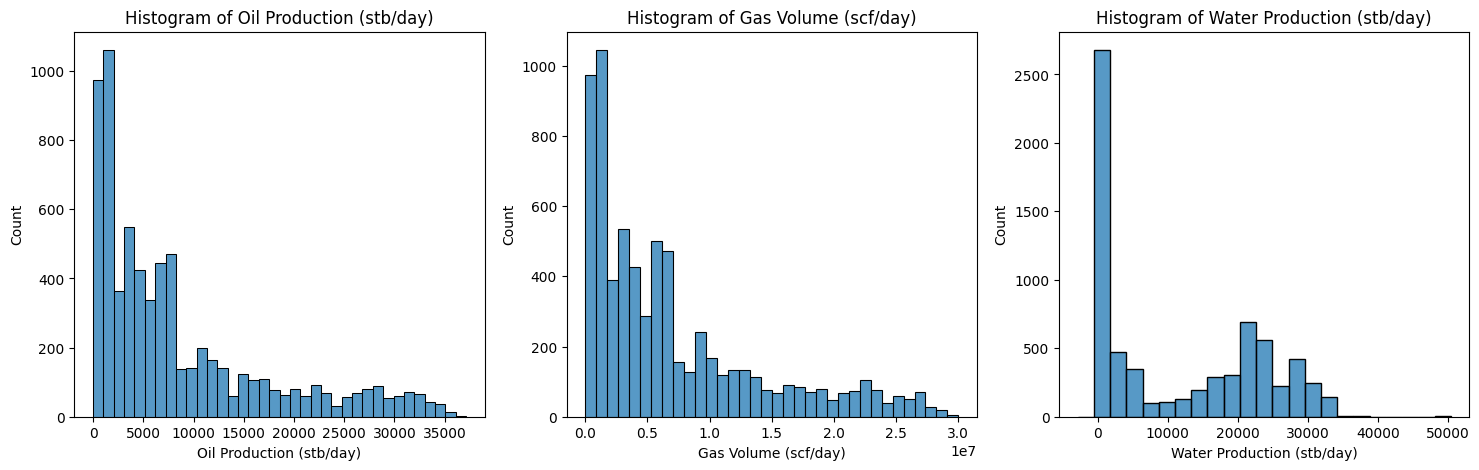

In [14]:
num_rows, num_cols = 1, 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5), gridspec_kw={'hspace': 0.3})

# Flatten the axes if there's only one row
if num_rows == 1:
    axes = [axes]

lst = ['Oil Production (stb/day)', 'Gas Volume (scf/day)', 'Water Production (stb/day)']

for i, col in enumerate(lst):
  ax = axes[i // num_cols][i % num_cols]
  sns.histplot(data=df, x=col, ax=ax)
  ax.set_title(f"Histogram of {col}")

# Show plots
plt.show()

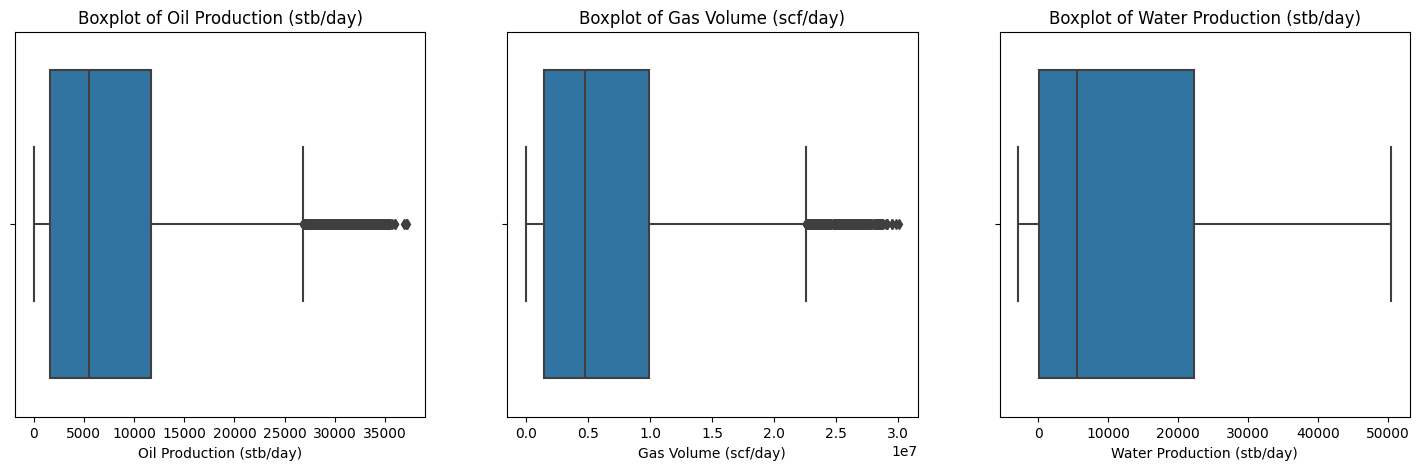

In [16]:
num_rows, num_cols = 1, 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5), gridspec_kw={'hspace': 0.3})

# Flatten the axes if there's only one row
if num_rows == 1:
    axes = [axes]

lst = ['Oil Production (stb/day)', 'Gas Volume (scf/day)', 'Water Production (stb/day)']

for i, col in enumerate(lst):
  ax = axes[i // num_cols][i % num_cols]
  sns.boxplot(data=df, x=col, ax=ax)
  ax.set_title(f"Boxplot of {col}")

# Show plots
plt.show()

Negative water production could imply error in recording/measurement or backflow of water into the reservoir. This means water is being injected into the well instead of being produced by the well. It is most likely an error in recording.

In [17]:
# Drop rows with negative water production
df = df[df['Water Production (stb/day)'] >= 0]

# Check number of records left
df.shape

(6921, 16)

In [18]:
# Split into numerical and categorical columns
cat_feature = ['Field Name', 'WELL_BORE_CODE', 'N_WELL_BORE_CODE', 'WellBore Name', 'FLOW_KIND', 'WELL_TYPE']
num_feature = [col for col in df.columns if col not in cat_feature]

# Remove production date from numerical columns
num_feature.remove('PRODUCTION DATE')

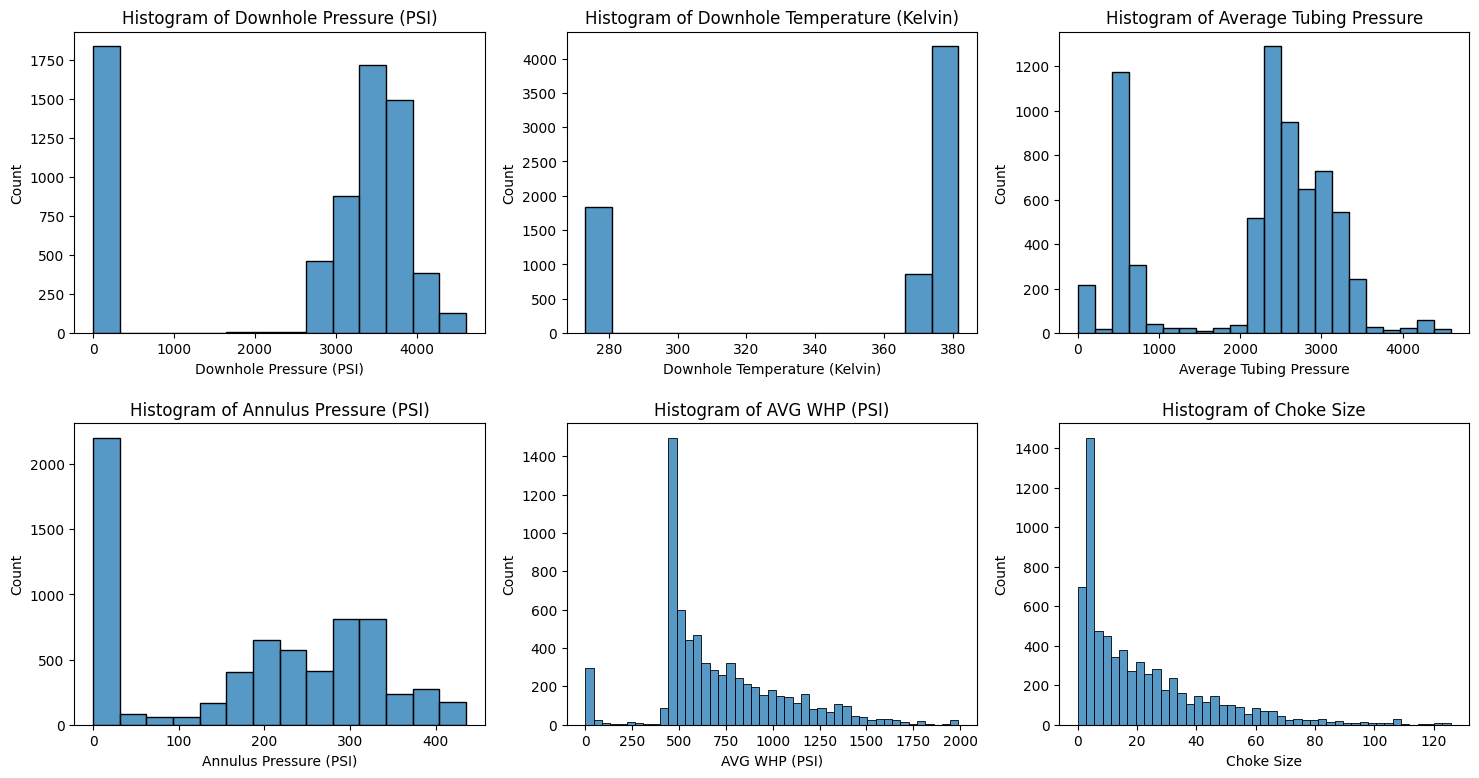

In [19]:
num_rows, num_cols = 2, 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 9), gridspec_kw={'hspace': 0.3})

# Flatten the axes if there's only one row
if num_rows == 1:
    axes = [axes]

for i, col in enumerate(num_feature[:-3]):
  ax = axes[i // num_cols][i % num_cols]
  sns.histplot(data=df, x=col, ax=ax)
  ax.set_title(f"Histogram of {col}")

# Show plots
plt.show()

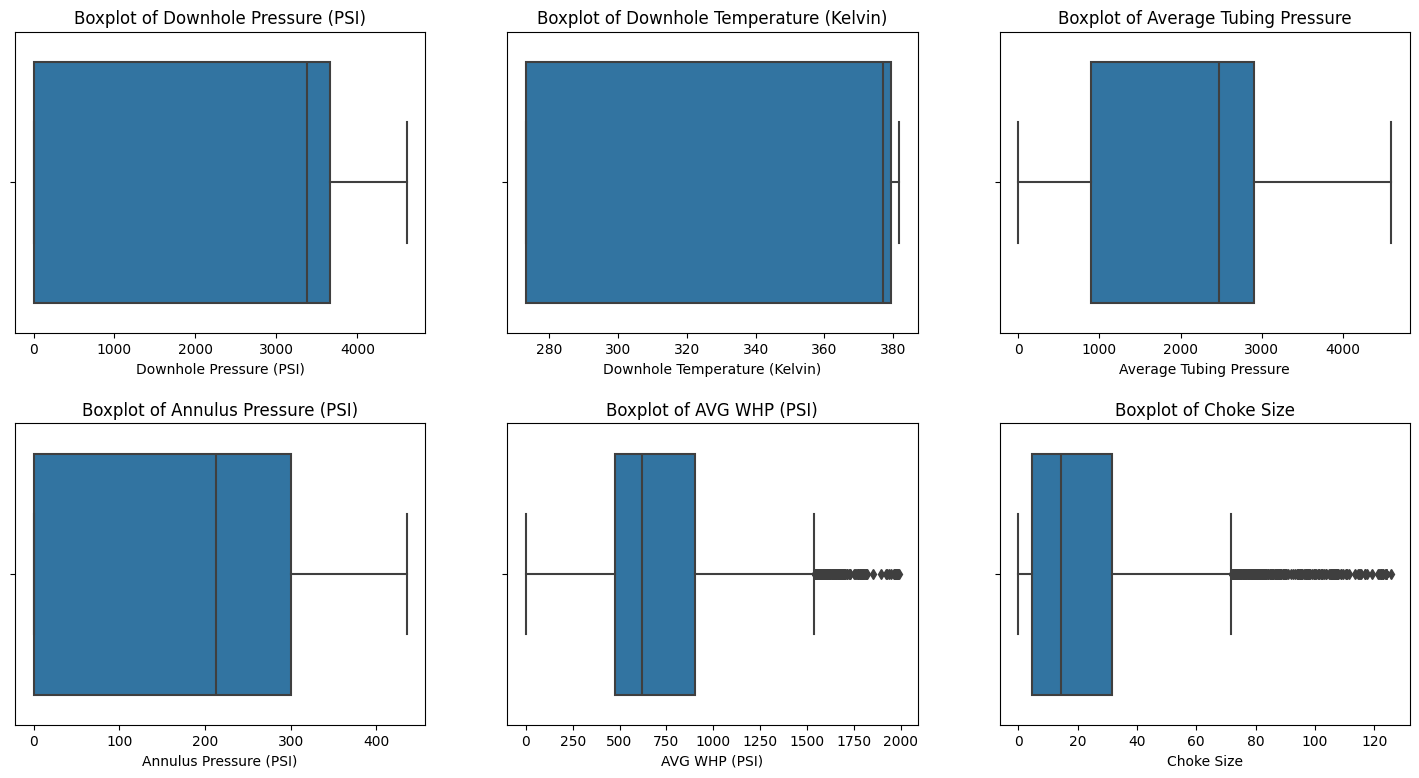

In [20]:
num_rows, num_cols = 2, 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 9), gridspec_kw={'hspace': 0.3})

# Flatten the axes if there's only one row
if num_rows == 1:
    axes = [axes]

for i, col in enumerate(num_feature[:-3]):
  ax = axes[i // num_cols][i % num_cols]
  sns.boxplot(data=df, x=col, ax=ax)
  ax.set_title(f"Boxplot of {col}")

# Show plots
plt.show()

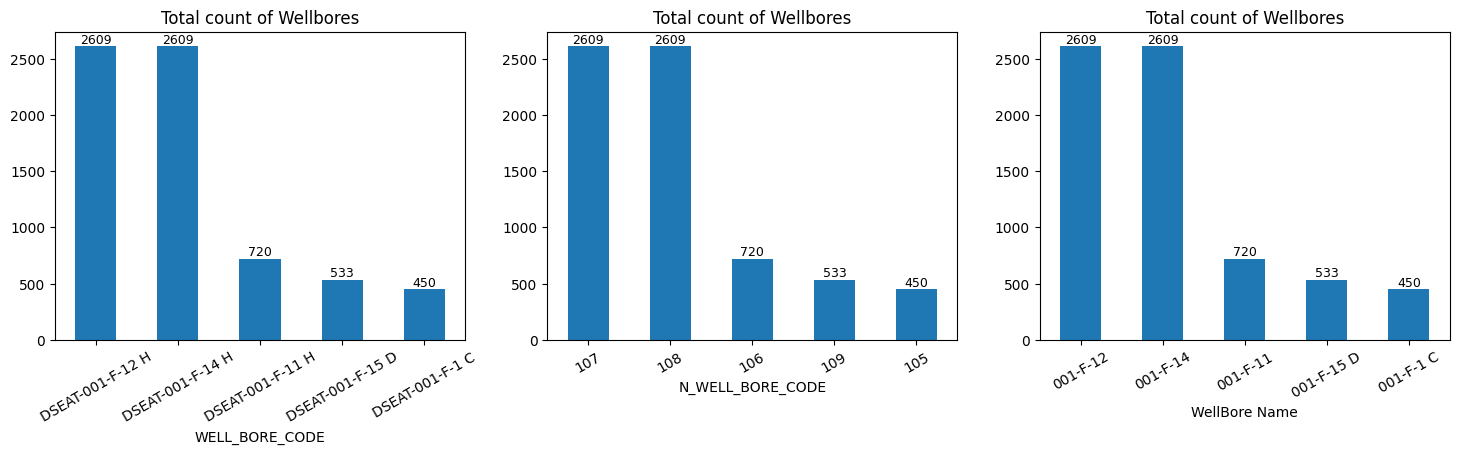

In [27]:
num_rows, num_cols = 1, 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 4), gridspec_kw={'hspace': 0.3})

# Flatten the axes if there's only one row
if num_rows == 1:
    axes = [axes]

for i, col in enumerate([cat_feature[1], cat_feature[2], cat_feature[3]]):
  ax = axes[i // num_cols][i % num_cols]
  #sns.countplot(data=df, x=col, ax=ax, hue=col, legend=None)
  df[col].value_counts().plot(kind='bar', ax=ax)
  ax.set_title('Total count of Wellbores')
  ax.tick_params(axis='x', rotation=30)
  for container in ax.containers:
    ax.bar_label(container, fontsize=9, fmt='%.0f')

# Show plots
plt.show()

**Field Name**, **WellBoreName** and **N_WELL_BORE_CODE** are mapped to **WELL_BORE_CODE** so they can be dropped.

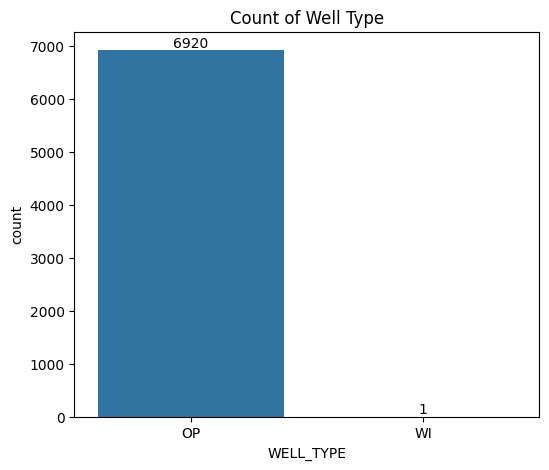

In [28]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.countplot(data=df, x='WELL_TYPE', ax=ax)
ax.bar_label(ax.containers[0], fontsize=10, fmt='%.0f')
plt.title('Count of Well Type')

# Show plot
plt.show()

In [29]:
# Check the record that is a well injector
df[df['WELL_TYPE'] == 'WI']

,PRODUCTION DATE,Field Name,WELL_BORE_CODE,N_WELL_BORE_CODE,WellBore Name,FLOW_KIND,WELL_TYPE,Downhole Pressure (PSI),Downhole Temperature (Kelvin),Average Tubing Pressure,Annulus Pressure (PSI),AVG WHP (PSI),Choke Size,Oil Production (stb/day),Gas Volume (scf/day),Water Production (stb/day)
91,2014-07-07,DSEAT,DSEAT-001-F-1 C,105,001-F-1 C,production,WI,3118.515828,381.28567,2354.897869,0.0,763.617959,24.2335,3283.38,2747990.628,971.6163


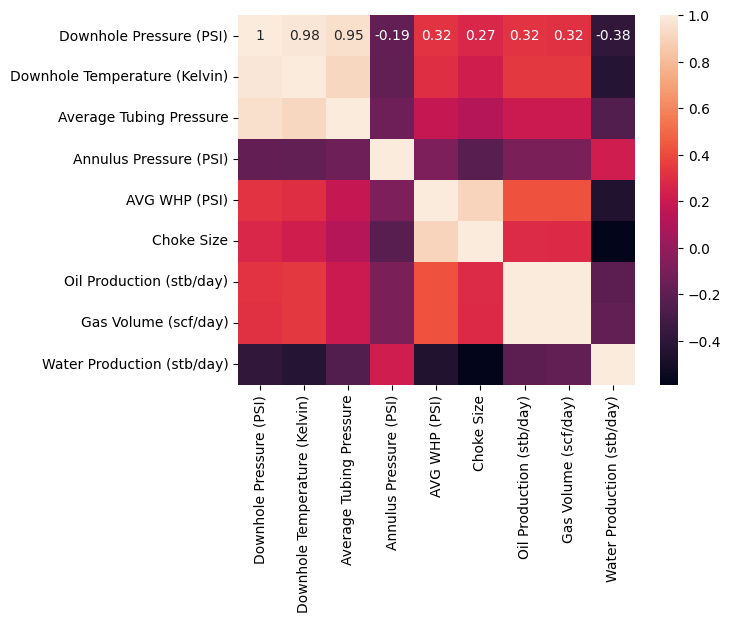

In [30]:
# Check the correlation of numeric features
sns.heatmap(df.corr(numeric_only=True), annot=True)

# Show plot
plt.show()

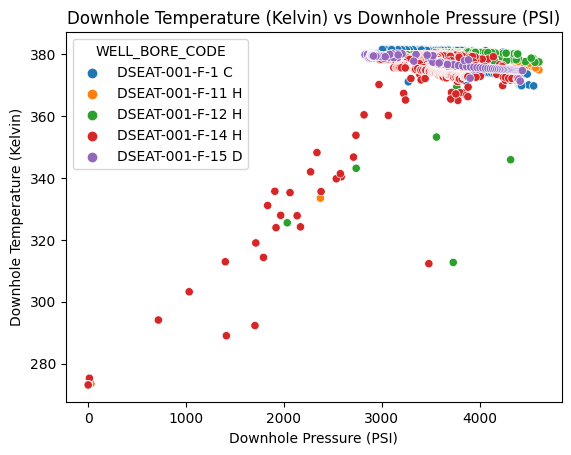

In [31]:
sns.scatterplot(data=df, x='Downhole Pressure (PSI)', y='Downhole Temperature (Kelvin)', hue='WELL_BORE_CODE')
plt.title('Downhole Temperature (Kelvin) vs Downhole Pressure (PSI)')

# Show plot
plt.show()

Downhole pressure and temperature are positively correlated. As temperature increases, pressure increases.

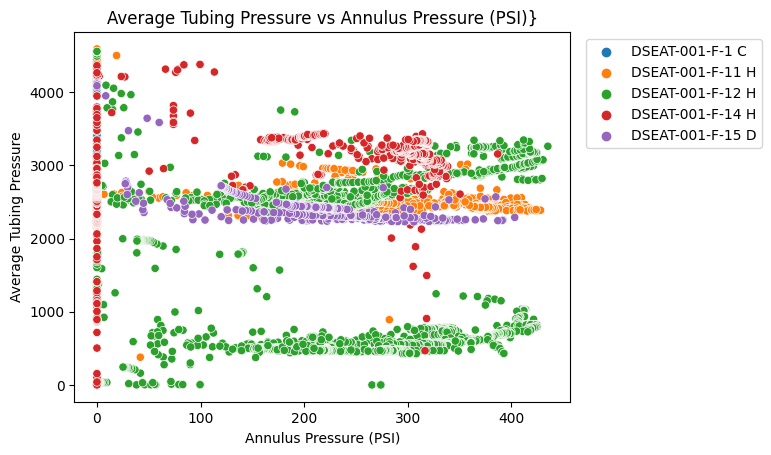

In [32]:
sns.scatterplot(data=df, x='Annulus Pressure (PSI)', y='Average Tubing Pressure', hue='WELL_BORE_CODE')
plt.title('Average Tubing Pressure vs Annulus Pressure (PSI)}')
plt.legend(bbox_to_anchor=(1.4, 1), loc='upper right')

# Show plot
plt.show()

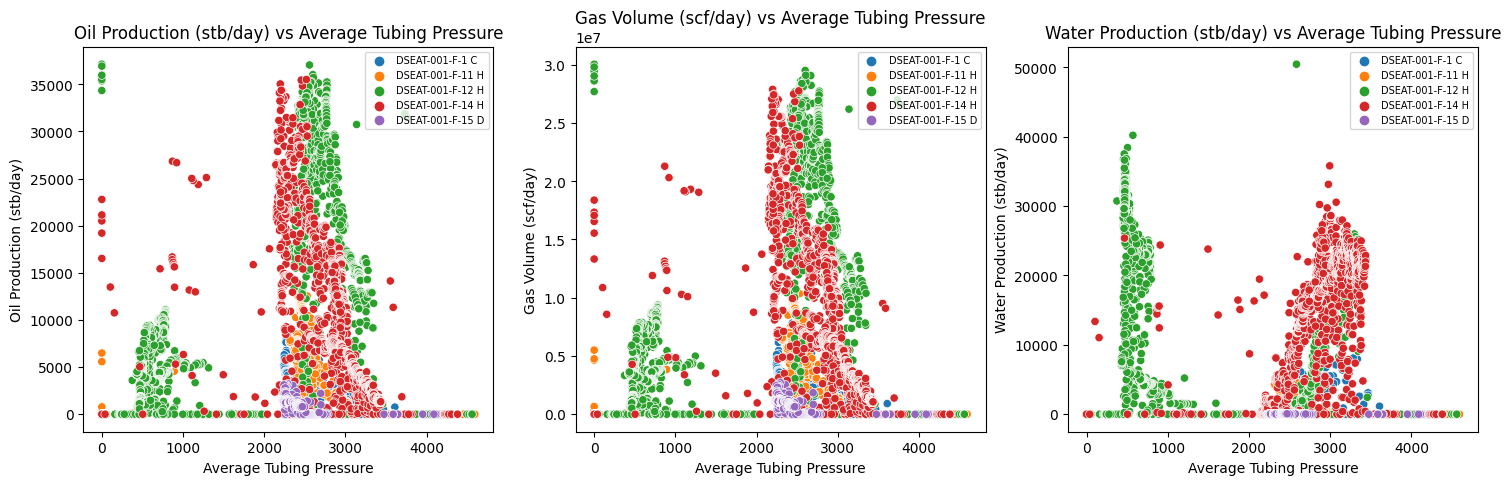

In [33]:
num_rows, num_cols = 1, 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5), gridspec_kw={'hspace': 0.3})

# Flatten the axes if there's only one row
if num_rows == 1:
    axes = [axes]

for i, col in enumerate(num_feature[-3:]):
  ax = axes[i // num_cols][i % num_cols]
  sns.scatterplot(data=df, x='Average Tubing Pressure', y=col, hue='WELL_BORE_CODE', ax=ax)
  ax.set_title(f"{col} vs Average Tubing Pressure")
  ax.legend(fontsize=7)

# Show plots
plt.show()

**DSEAT-001-F-14 H** produces water more at an Average Tubing Pressure of >2000 PSI while **DSEAT-001-F-12 H** could produce well at <1000 PSI.

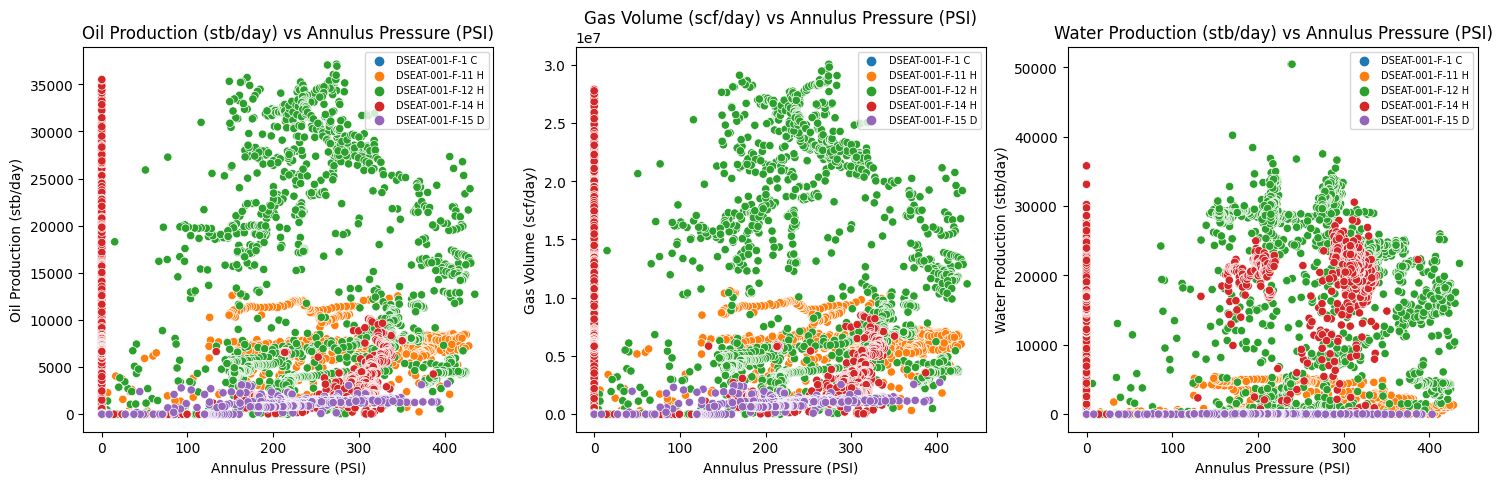

In [34]:
num_rows, num_cols = 1, 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5), gridspec_kw={'hspace': 0.3})

# Flatten the axes if there's only one row
if num_rows == 1:
    axes = [axes]

for i, col in enumerate(num_feature[-3:]):
  ax = axes[i // num_cols][i % num_cols]
  sns.scatterplot(data=df, x='Annulus Pressure (PSI)', y=col, hue='WELL_BORE_CODE', ax=ax)
  ax.set_title(f"{col} vs Annulus Pressure (PSI)")
  ax.legend(fontsize=7)

# Show plots
plt.show()

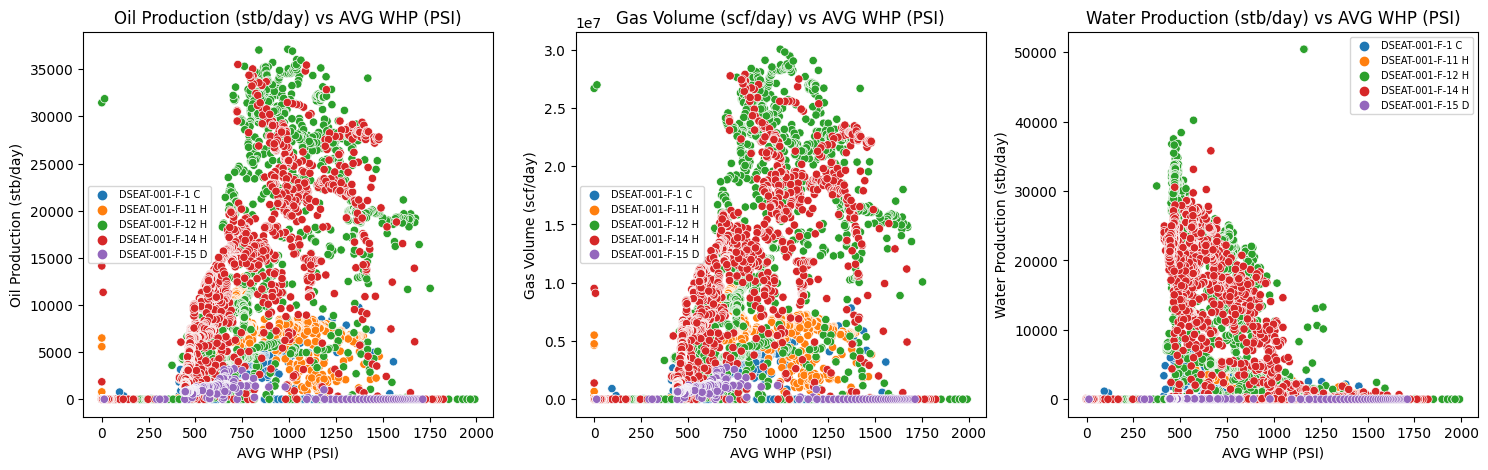

In [35]:
num_rows, num_cols = 1, 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5), gridspec_kw={'hspace': 0.3})

# Flatten the axes if there's only one row
if num_rows == 1:
    axes = [axes]

for i, col in enumerate(num_feature[-3:]):
  ax = axes[i // num_cols][i % num_cols]
  sns.scatterplot(data=df, x='AVG WHP (PSI)', y=col, hue='WELL_BORE_CODE', ax=ax)
  ax.set_title(f"{col} vs AVG WHP (PSI)")
  ax.legend(fontsize=7)

# Show plots
plt.show()

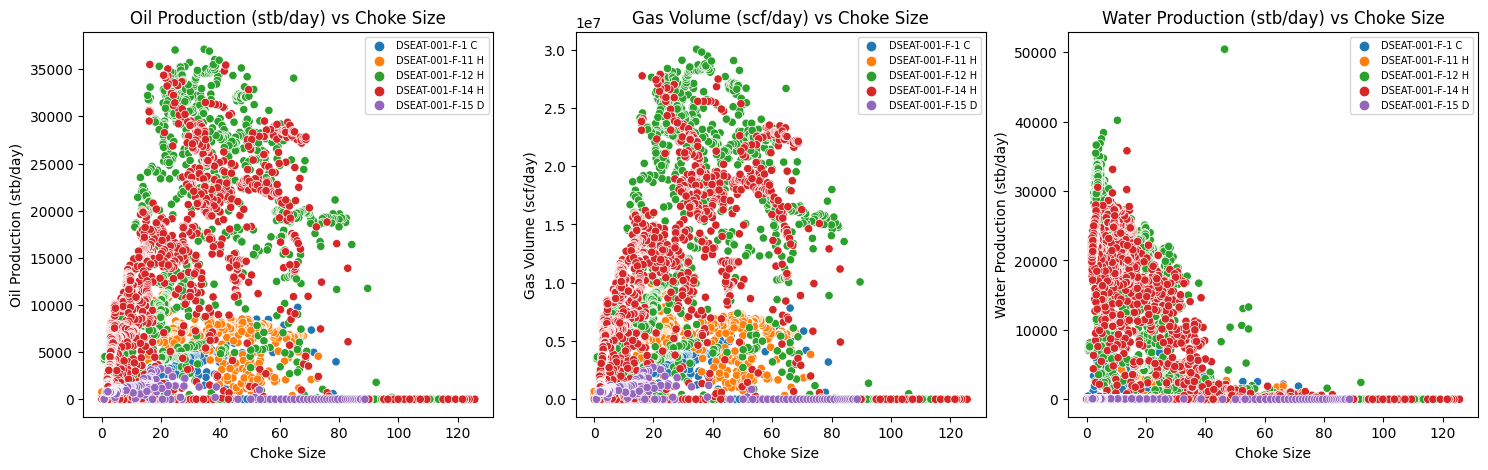

In [36]:
num_rows, num_cols = 1, 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5), gridspec_kw={'hspace': 0.3})

# Flatten the axes if there's only one row
if num_rows == 1:
    axes = [axes]

for i, col in enumerate(num_feature[-3:]):
  ax = axes[i // num_cols][i % num_cols]
  sns.scatterplot(data=df, x='Choke Size', y=col, hue='WELL_BORE_CODE', ax=ax)
  ax.set_title(f"{col} vs Choke Size")
  ax.legend(fontsize=7)

# Show plots
plt.show()

In [37]:
# Check for records with parameters equal to 0 but have production data
df[((df['Downhole Pressure (PSI)'] == 0) &
  (df['Average Tubing Pressure'] == 0) &
  (df['AVG WHP (PSI)'] == 0) &
  (df['Choke Size'] == 0) &
  (df['Annulus Pressure (PSI)'] == 0)) &
  ((df['Oil Production (stb/day)'] != 0) |
  (df['Gas Volume (scf/day)'] != 0) |
  (df['Water Production (stb/day)'] != 0))]

,PRODUCTION DATE,Field Name,WELL_BORE_CODE,N_WELL_BORE_CODE,WellBore Name,FLOW_KIND,WELL_TYPE,Downhole Pressure (PSI),Downhole Temperature (Kelvin),Average Tubing Pressure,Annulus Pressure (PSI),AVG WHP (PSI),Choke Size,Oil Production (stb/day),Gas Volume (scf/day),Water Production (stb/day)
470,2013-07-28,DSEAT,DSEAT-001-F-11 H,106,001-F-11,production,OP,0.0,273.15,0.0,0.0,0.0,0.0,352.3029,318115.481,0.0
471,2013-07-29,DSEAT,DSEAT-001-F-11 H,106,001-F-11,production,OP,0.0,273.15,0.0,0.0,0.0,0.0,777.3811,663375.250,0.0


In [38]:
# Drop rows with parameters equal to 0 but have production data
df.drop([470, 471], inplace=True)

Check for the wellbores with no value and no production data.

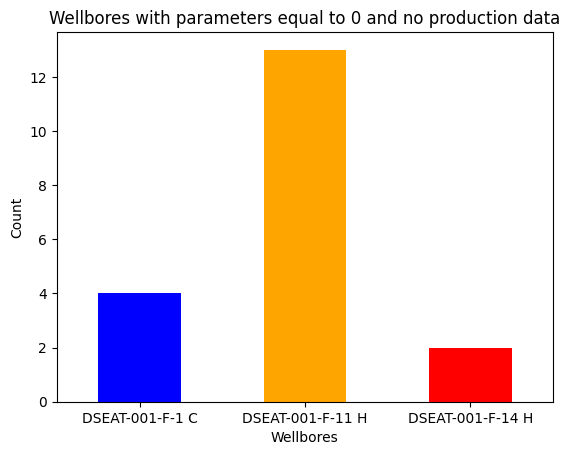

In [39]:
df[(df['Downhole Pressure (PSI)'] == 0) &
  (df['Average Tubing Pressure'] == 0) &
  (df['AVG WHP (PSI)'] == 0) &
  (df['Choke Size'] == 0) &
  (df['Annulus Pressure (PSI)'] == 0)].groupby('WELL_BORE_CODE')['Average Tubing Pressure'].count().plot(kind='bar', color=['blue', 'orange', 'red'])

plt.title('Wellbores with parameters equal to 0 and no production data')
plt.xlabel('Wellbores')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Show plot
plt.show()

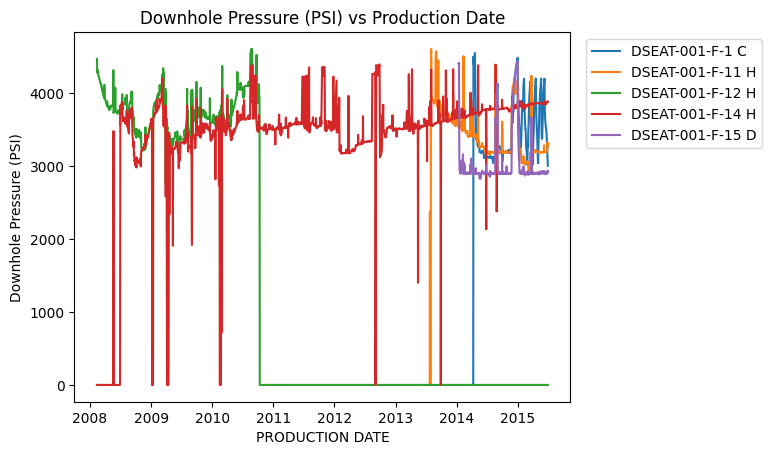

In [40]:
sns.lineplot(data=df, x='PRODUCTION DATE', y='Downhole Pressure (PSI)', hue='WELL_BORE_CODE', ci=None)
plt.title('Downhole Pressure (PSI) vs Production Date')
plt.legend(bbox_to_anchor=(1.4, 1), loc='upper right')

# Show plot
plt.show()

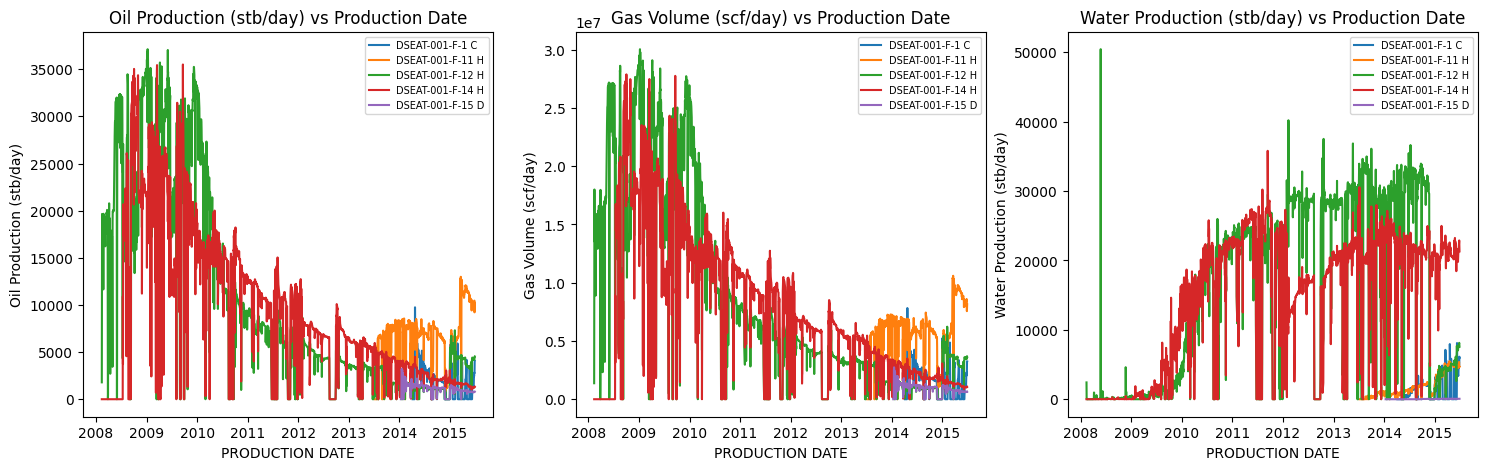

In [41]:
num_rows, num_cols = 1, 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5), gridspec_kw={'hspace': 0.3})

# Flatten the axes if there's only one row
if num_rows == 1:
    axes = [axes]

for i, col in enumerate(num_feature[-3:]):
  ax = axes[i // num_cols][i % num_cols]
  sns.lineplot(data=df, x='PRODUCTION DATE', y=col, hue='WELL_BORE_CODE', ax=ax)
  ax.set_title(f"{col} vs Production Date")
  ax.legend(fontsize=7)

# Show plots
plt.show()

There is a decline in production of oil and gas with time. However, water production seems to increase with time.

In [42]:
# Extract the year for each record
df['Year'] = df['PRODUCTION DATE'].dt.year

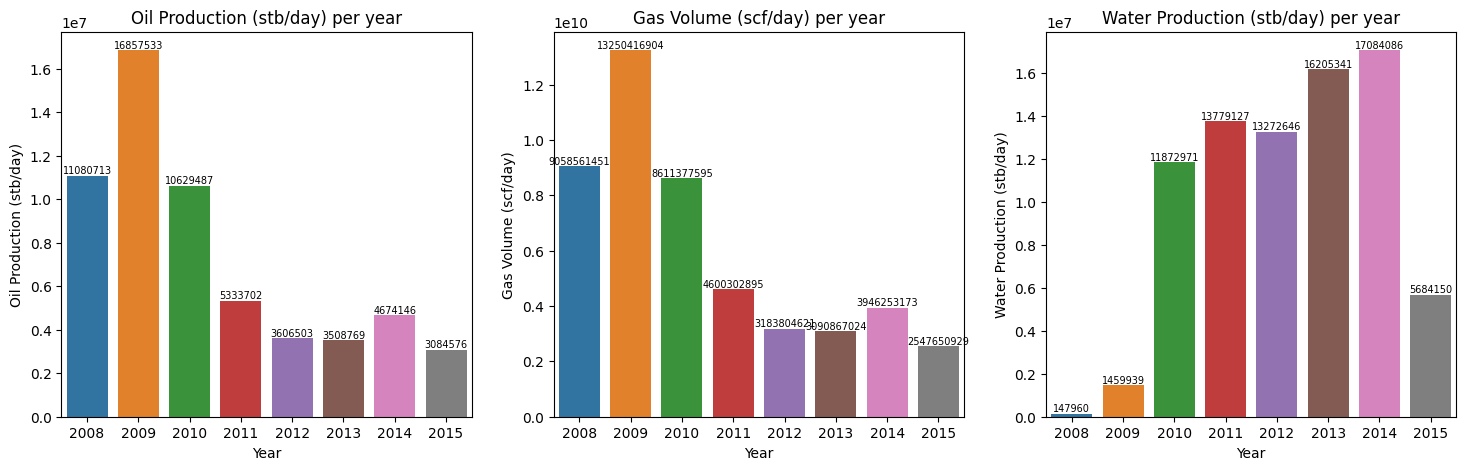

In [43]:
num_rows, num_cols = 1, 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5), gridspec_kw={'hspace': 0.3})

# Flatten the axes if there's only one row
if num_rows == 1:
    axes = [axes]

for i, col in enumerate(num_feature[-3:]):
  ax = axes[i // num_cols][i % num_cols]
  sns.barplot(data=df, x='Year', y=col, estimator='sum', ci=None, ax=ax)
  ax.set_title(f"{col} per year")
  for container in ax.containers:
    ax.bar_label(container, fontsize=7, fmt='%.0f')

# Show plots
plt.show()

# Feature Engineering

In [44]:
# Get the number of unique values in each column
for col in df.columns:
  print(f"There are {df[col].nunique()} unique values in {col}")

There are 2610 unique values in PRODUCTION DATE
There are 1 unique values in Field Name
There are 5 unique values in WELL_BORE_CODE
There are 5 unique values in N_WELL_BORE_CODE
There are 5 unique values in WellBore Name
There are 1 unique values in FLOW_KIND
There are 2 unique values in WELL_TYPE
There are 5047 unique values in Downhole Pressure (PSI)
There are 4980 unique values in Downhole Temperature (Kelvin)
There are 6706 unique values in Average Tubing Pressure
There are 4797 unique values in Annulus Pressure (PSI)
There are 6709 unique values in AVG WHP (PSI)
There are 6852 unique values in Choke Size
There are 6138 unique values in Oil Production (stb/day)
There are 6234 unique values in Gas Volume (scf/day)
There are 5639 unique values in Water Production (stb/day)
There are 8 unique values in Year


**Downhole Temperature (Kelvin)** exhibits multi-collinearity with **Downhole Presure (PSI)** and **Average Tubing Pressure**. Since **Downhole Temperature (Kelvin)** closely represents **Downhole Pressure (PSI)**, it can be dropped.

In [45]:
# Create a copy of the dataframe
df_copy = df.copy()

In [46]:
def create_lagged_features(df, targets, lag):

  # Create lagged features
  for lag in range(1, lag + 1):
    for col in targets:
      df[f'{col}_lag_{lag}'] = df[col].shift(lag)

  return df

In [47]:
# Create a feature transformation function
def feature_transform(data):

  # Drop redundant columns
  data.drop(columns=['Field Name', 'WellBore Name', 'N_WELL_BORE_CODE', 'Downhole Temperature (Kelvin)', 'PRODUCTION DATE'], inplace=True)

  # Drop Year column
  if 'Year' in data.columns:
    data.drop(columns=['Year'], inplace=True)

  return data

In [48]:
# Create lagged features
df_copy = create_lagged_features(df_copy, ['Oil Production (stb/day)', 'Gas Volume (scf/day)', 'Water Production (stb/day)'], 3)

# Drop rows with NaN values (due to lagging)
df_copy.dropna(inplace=True)

In [49]:
# Apply function to df_copy
df_copy = feature_transform(df_copy)

In [50]:
# Apply log transformation to skewed features
for feature in df_copy.columns.tolist()[6:]:
  df_copy[feature] = df_copy[feature].apply(lambda x: np.log(x) if x > 0 else 0)

# Model Development

In [51]:
# Split into features and target
X = df_copy.drop(columns=['Oil Production (stb/day)', 'Gas Volume (scf/day)', 'Water Production (stb/day)'])
y = df_copy[['Oil Production (stb/day)', 'Gas Volume (scf/day)', 'Water Production (stb/day)']]

In [52]:
# Select numerical and categorical columns
num_cols_X = X.select_dtypes(include=float).columns.tolist()
cat_cols_X = X.select_dtypes(include=object).columns.tolist()

In [53]:
# Select 80% as train data
train_size = int(len(df_copy) * 0.8)

# Split the data
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [54]:
# Create a pipeline to handle preprocessing
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols_X),
        ('cat', categorical_transformer, cat_cols_X)
])

In [55]:
# Create a model pipeline with parameters
param_grid = [
    {'regressor__estimator': [LinearRegression()]},
    {
        'regressor__estimator': [Lasso(), Ridge()],
        'regressor__estimator__alpha': [0.1, 1, 10],
        'regressor__estimator__max_iter': [1000, 2000],
        'regressor__estimator__tol': [0.0001, 0.001, 0.01]
    },
    {
        'regressor__estimator': [RandomForestRegressor(random_state=42), xgb.XGBRegressor(random_state=42)],
        'regressor__estimator__n_estimators': [100, 200, 300],
    }
]

model = Pipeline(steps=[
    #('feature_transform', feature_transform),
    ('preprocessor', preprocessor),
    ('regressor', MultiOutputRegressor(LinearRegression()))
])

In [56]:
# Perform hyperparameter tuning and fit the model
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Downhole '
                                                                          'Pressure '
                                                                          '(PSI)',
                                                                          'Average '
                                                                          'Tubing '
                                                                          'Pressure',
                                                                          'Annulus '
                                                                          'Pressure '
                                                                          '(PSI)',
                                                                          'AVG '
                                                                          'WHP '
                                                                          '(PSI)',
                                                                          'Choke '
                                                                          'Size',
                                                                          'Oil '
                                                                          'Production '
                                                                          '(stb/day)_lag_1',
                                                                          'Gas '
                                                                          'Volume '
                                                                          '(scf/day)_lag_1',
                                                                          'Water '
                                                                          'Production '
                                                                          '(st...
                                                                max_bin=None,
                                                                max_cat_threshold=None,
                                                                max_cat_to_onehot=None,
                                                                max_delta_step=None,
                                                                max_depth=None,
                                                                max_leaves=None,
                                                                min_child_weight=None,
                                                                missing=nan,
                                                                monotone_constraints=None,
                                                                multi_strategy=None,
                                                                n_estimators=None,
                                                                n_jobs=None,
                                                                num_parallel_tree=None,
                                                                random_state=42, ...)],
                          'regressor__estimator__n_estimators': [100, 200,
                                                                 300]}],
             scoring='neg_mean_squared_error')

In [57]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Downhole Pressure (PSI)',
                                                   'Average Tubing Pressure',
                                                   'Annulus Pressure (PSI)',
                                                   'AVG WHP (PSI)',
                                                   'Choke Size',
                                                   'Oil Production '
                                                   '(stb/day)_lag_1',
                                                   'Gas Volume (scf/day)_lag_1',
                                                   'Water Production '
                                                   '(stb/day)_lag_1',
                                                   'Oil Production '
                                                   '(stb/day)_lag_2',
                                                   'Gas Volume (scf/day)_lag_2',
                                                   'Water Production '
                                                   '(stb/day)_lag_2',
                                                   'Oil Production '
                                                   '(stb/day)_lag_3',
                                                   'Gas Volume (scf/day)_lag_3',
                                                   'Water Production '
                                                   '(stb/day)_lag_3']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['WELL_BORE_CODE',
                                                   'FLOW_KIND',
                                                   'WELL_TYPE'])])),
                ('regressor',
                 MultiOutputRegressor(estimator=Lasso(alpha=0.1)))])

In [58]:
# Select best model
best_model = grid_search.best_estimator_

# Predict on X_test
y_pred_log = best_model.predict(X_test)

In [59]:
# Extract the original values
y_pred = np.exp(y_pred_log)

In [60]:
# Check r2 score
r2_score(np.exp(y_test), y_pred)

0.815359343782839

In [61]:
# Calculate Mean Squared Error for each target
mse_scores = [mean_squared_error(np.exp(y_test).iloc[:, i], y_pred[:, i]) for i in range(y_pred.shape[1])]

# Print or use the MSE scores as needed
print(mse_scores)

[555048.2020175314, 403307909028.52844, 13834700.990937212]


In [62]:
# Calculate Root Mean Squared Error for each target
rmse_scores = [np.sqrt(mean_squared_error(np.exp(y_test).iloc[:, i], y_pred[:, i])) for i in range(y_pred.shape[1])]

# Print or use the RMSE scores as needed
print(rmse_scores)

[745.0155716611106, 635065.2793442013, 3719.5027881340825]


In [63]:
# Calculate Mean Absolute Error for each target
mae_scores = [mean_absolute_error(np.exp(y_test).iloc[:, i], y_pred[:, i]) for i in range(y_pred.shape[1])]

# Print or use the MAE scores as needed
print(mae_scores)

[418.73792158145915, 349249.41929812933, 1885.0543824699687]


In [64]:
# Convert predictions to dataframe
y_pred_df = pd.DataFrame(y_pred, columns=['Oil Production (stb/day)', 'Gas Volume (scf/day)', 'Water Production (stb/day)'])

# Print dataframe
y_pred_df

,Oil Production (stb/day),Gas Volume (scf/day),Water Production (stb/day)
0,5351.180166,5.071080e+06,19682.549985
1,5152.366973,4.796662e+06,19171.955413
2,5426.960394,4.830495e+06,18227.431588
3,4345.915454,3.999347e+06,15759.012281
4,5194.761677,4.882350e+06,19395.168724
...,...,...,...
1377,927.348475,5.078160e+05,120.654170
1378,924.770742,5.015099e+05,119.867444
1379,919.931003,4.951160e+05,120.870776
1380,951.133018,5.208775e+05,125.260563


In [67]:
# Save the model to a file
filename = 'model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)

# Validation Set

In [65]:
# Read in the dataset
valid_df = pd.read_csv('dseats_2024_validation_dataset.csv', parse_dates=['PRODUCTION DATE'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S'))

In [419]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9920 entries, 0 to 9919
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   PRODUCTION DATE                2075 non-null   datetime64[ns]
 1   Field Name                     2075 non-null   object        
 2   WELL_BORE_CODE                 2075 non-null   object        
 3   N_WELL_BORE_CODE               2075 non-null   float64       
 4   WellBore Name                  2075 non-null   object        
 5   FLOW_KIND                      2075 non-null   object        
 6   WELL_TYPE                      2075 non-null   object        
 7   Downhole Pressure (PSI)        2075 non-null   float64       
 8   Downhole Temperature (Kelvin)  2075 non-null   float64       
 9   Average Tubing Pressure        2075 non-null   float64       
 10  Annulus Pressure (PSI)         2075 non-null   float64       
 11  AVG WHP (PSI)    

In [420]:
# Select rows with complete data
valid_df.dropna(inplace=True, how='all')

In [421]:
targets = ['Oil Production (stb/day)', 'Gas Volume (scf/day)', 'Water Production (stb/day)']

# Combine the last few rows of the training set with the validation set to create lagged features
df_combined = pd.concat([df.drop(columns=['Year']).tail(3), valid_df])

In [422]:
# Create lagged features from combined set
df_val_lagged = create_lagged_features(df_combined, targets, 3)

# Drop the initial rows used to create lagged features
df_val_lagged = df_val_lagged.iloc[3:]

# Drop targets
X_val = df_val_lagged.drop(columns=targets)

In [423]:
# Apply feature_transform function
X_val = feature_transform(X_val)

In [424]:
# Initialize an empty DataFrame to store predictions
predictions_df = pd.DataFrame(index=X_val.index, columns=targets)

In [425]:
# Create a X_val copy
X_val_copy = X_val.copy()

In [426]:
for i in range(len(X_val_copy)):
    # Apply log transformation to skewed features
    for feature in X_val_copy.columns.tolist()[6:]:
      X_val_copy.loc[i, feature] = np.log(X_val_copy.loc[i, feature]) if X_val_copy.loc[i, feature] > 0 else 0

    # Select the current instance
    X_val_copy_instance = X_val_copy.iloc[[i]].copy()

    # # Predict for that instance
    y_pred_instance = best_model.predict(X_val_copy_instance)

    # Store the predictions
    predictions_df.iloc[i] = y_pred_instance[0]

    # Update the lagged features
    if i < len(X_val_copy) - 4:
        for j, col in enumerate(targets):
            X_val_copy.iloc[i + 1, X_val_copy.columns.get_loc(f'{col}_lag_1')] = np.exp(y_pred_instance[0][j])
            for lag in range(2, 4):  # Adjust to the number of lags used
                X_val_copy.iloc[i + lag, X_val_copy.columns.get_loc(f'{col}_lag_{lag}')] = X_val_copy.iloc[i + lag - 1, X_val_copy.columns.get_loc(f'{col}_lag_{lag - 1}')]

In [427]:
# Join the predictions to the validation dataframe
valid_df_copy = valid_df.copy()
valid_df_copy[targets] = np.array(predictions_df)

In [428]:
# Take the exponent of the predicted values to obtain the original values in their respective scales
valid_df_copy[targets] = valid_df_copy[targets].applymap(np.exp)

In [430]:
valid_df_copy.head()

,PRODUCTION DATE,Field Name,WELL_BORE_CODE,N_WELL_BORE_CODE,WellBore Name,FLOW_KIND,WELL_TYPE,Downhole Pressure (PSI),Downhole Temperature (Kelvin),Average Tubing Pressure,Annulus Pressure (PSI),AVG WHP (PSI),Choke Size,Oil Production (stb/day),Gas Volume (scf/day),Water Production (stb/day)
0,2015-07-01,DSEAT,DSEAT-001-F-1 C,105.0,001-F-1 C,production,OP,3061.253047,380.665745,2659.809580,0.0,401.443468,0.491632,889.549883,434231.466746,128.026574
1,2015-07-02,DSEAT,DSEAT-001-F-1 C,105.0,001-F-1 C,production,OP,3247.951135,376.759980,2547.453670,0.0,700.497465,21.775180,1086.021342,331067.226365,139.267866
2,2015-07-03,DSEAT,DSEAT-001-F-1 C,105.0,001-F-1 C,production,OP,3333.012485,375.985300,2533.912265,0.0,799.100220,27.638780,1284.887236,318734.502074,145.093089
3,2015-07-04,DSEAT,DSEAT-001-F-1 C,105.0,001-F-1 C,production,OP,3404.022465,375.419010,2481.804485,0.0,922.217980,36.178940,1509.560136,350103.533790,165.808809
4,2015-07-05,DSEAT,DSEAT-001-F-1 C,105.0,001-F-1 C,production,OP,3465.473030,375.004710,2408.310945,0.0,1057.162085,45.424140,1785.552471,419610.841965,182.480540


In [431]:
valid_df_copy.to_csv('Simeon_Akinsanya_2024_DSEATS_Datathon_5742992.csv', index=False)